# Pre-process EGF Dataset

**Publication**: Song Feng et al. A Phosphoproteomics Data Resource for Systems-level Modeling of Kinase Signaling Networks

In [1]:
import pandas as pd
import numpy as np
import os
import re

import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

In [2]:
file_path = os.path.join('..', 'data_raw', 'EGFR_Phosphoproteomics_Analysis-main/phospho_proteomics_data', 'EGF_timecourse_phospho.csv')
egf_data = pd.read_csv(file_path, delimiter=';')
display(egf_data.head())

,Peptide,Site,UniProt,Protein,Residue,avgRII,AScore,MCF10A_Control_R1_01,MCF10A_Control_R2_02,MCF10A_EGF_2m_R1_03,MCF10A_EGF_2m_R2_04,MCF10A_EGF_4m_R1_05,MCF10A_EGF_4m_R2_06,MCF10A_EGF_8m_R1_07,MCF10A_EGF_8m_R2_08,MCF10A_EGF_12m_R1_09,MCF10A_EGF_12m_R2_10
0,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-,NUD4B_HUMAN-S149s,A0A024RBG1,NUD4B_HUMAN,S149s,"15,77447175","56,631","-0,577500405","-0,771579658","-0,895769868","-0,75560508","-1,180759266","-0,523763447","-0,190640437","-0,181654911","-0,257565667","-0,621440886"
1,K.GS*CFHR.I,PAL4E_HUMAN-S51s,A0A075B759,PAL4E_HUMAN,S51s,"18,44343589",1000,"-0,105586224","0,36024423","0,434935269","0,144713319","-0,375717013","-0,04657414","-0,040843824","0,062768224","-0,189391465","0,15516686"
2,K.T*AENFR.A,PAL4E_HUMAN-T32t,A0A075B759,PAL4E_HUMAN,T32t,"17,31134981",1000,"-0,4719188","0,060732761","0,232354728","0,087399966","-0,417820143","0,033339567","-0,290002323","-0,279579337","-0,224113643","-0,195858809"
3,K.DVLESGLS*PGKYY*THT*PR.R,TRGV5_HUMAN-S82sY87yT90t,A0A0B4J1U4,TRGV5_HUMAN,S82sY87yT90t,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"
4,K.SPAGLSGTPATQGLLGACS*PVR.L,SIK1B_HUMAN-S534s,A0A0B4J2F2,SIK1B_HUMAN,S534s,"15,73845037","85,186","-0,089877","-0,487156956","-0,526757727","-0,099866359","0,182324833","-0,184955362","-0,000835477","0,425625665","-0,146218358","-0,118398189"


In [3]:
egf_data = egf_data.drop(columns=["Site"])
egf_data["Protein"] = egf_data["Protein"].str.replace("_HUMAN", "", regex=False)
egf_data["Residue_split"] = egf_data["Residue"].apply(lambda x: re.findall(r'([A-Z]\d+[a-z])', x))
egf_data = egf_data.explode("Residue_split").reset_index(drop=True)
egf_data = egf_data.drop(columns=["Residue"]).rename(columns={"Residue_split": "Residue"})
egf_data["site_id"] = egf_data["Protein"] + ":" + egf_data["UniProt"] + ":" + egf_data["Residue"]
egf_data = egf_data.rename(columns={
    'Peptide': 'modified_peptide_sequence',
    'Residue': 'phosphosite',
    'Protein': 'gene_id',
    'UniProt': 'protein_id'
})

# Reorder columns so that the first columns are the desired ones.
first_cols = ['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']
remaining_cols = [c for c in egf_data.columns if c not in first_cols]
egf_data = egf_data[first_cols + remaining_cols]

# Aggregate rows with the same site_id
# For numeric columns, take the median, for non-numeric ones, we take the first entry.
agg_dict = {}
for col in egf_data.columns:
    if col in first_cols:
        agg_dict[col] = 'first'
    else:
        if pd.api.types.is_numeric_dtype(egf_data[col]):
            agg_dict[col] = 'median'
        else:
            agg_dict[col] = 'first'
            
egf_data = egf_data.groupby('site_id', as_index=False, sort=False).agg(agg_dict)

display(egf_data.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence,avgRII,AScore,MCF10A_Control_R1_01,MCF10A_Control_R2_02,MCF10A_EGF_2m_R1_03,MCF10A_EGF_2m_R2_04,MCF10A_EGF_4m_R1_05,MCF10A_EGF_4m_R2_06,MCF10A_EGF_8m_R1_07,MCF10A_EGF_8m_R2_08,MCF10A_EGF_12m_R1_09,MCF10A_EGF_12m_R2_10
0,NUD4B:A0A024RBG1:S149s,NUD4B,A0A024RBG1,S149s,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-,"15,77447175","56,631","-0,577500405","-0,771579658","-0,895769868","-0,75560508","-1,180759266","-0,523763447","-0,190640437","-0,181654911","-0,257565667","-0,621440886"
1,PAL4E:A0A075B759:S51s,PAL4E,A0A075B759,S51s,K.GS*CFHR.I,"18,44343589",1000,"-0,105586224","0,36024423","0,434935269","0,144713319","-0,375717013","-0,04657414","-0,040843824","0,062768224","-0,189391465","0,15516686"
2,PAL4E:A0A075B759:T32t,PAL4E,A0A075B759,T32t,K.T*AENFR.A,"17,31134981",1000,"-0,4719188","0,060732761","0,232354728","0,087399966","-0,417820143","0,033339567","-0,290002323","-0,279579337","-0,224113643","-0,195858809"
3,TRGV5:A0A0B4J1U4:S82s,TRGV5,A0A0B4J1U4,S82s,K.DVLESGLS*PGKYY*THT*PR.R,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"
4,TRGV5:A0A0B4J1U4:Y87y,TRGV5,A0A0B4J1U4,Y87y,K.DVLESGLS*PGKYY*THT*PR.R,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"


In [4]:
# Split the DataFrame into map_protein and phospho_data
map_protein = egf_data[['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']]
phospho_data = egf_data[['site_id', 'MCF10A_Control_R1_01', 'MCF10A_Control_R2_02', 'MCF10A_EGF_2m_R1_03', 'MCF10A_EGF_2m_R2_04', 'MCF10A_EGF_4m_R1_05', 'MCF10A_EGF_4m_R2_06', 'MCF10A_EGF_8m_R1_07', 'MCF10A_EGF_8m_R2_08', 'MCF10A_EGF_12m_R1_09', 'MCF10A_EGF_12m_R2_10']].copy()
phospho_data = phospho_data.rename(columns={
    'MCF10A_Control_R1_01': 'R1_0',
    'MCF10A_Control_R2_02': 'R2_0',
    'MCF10A_EGF_2m_R1_03': 'R1_2',
    'MCF10A_EGF_2m_R2_04': 'R2_2',
    'MCF10A_EGF_4m_R1_05': 'R1_4',
    'MCF10A_EGF_4m_R2_06': 'R2_4',
    'MCF10A_EGF_8m_R1_07': 'R1_8',
    'MCF10A_EGF_8m_R2_08': 'R2_8',
    'MCF10A_EGF_12m_R1_09': 'R1_12',
    'MCF10A_EGF_12m_R2_10': 'R2_12',
})

# Long-transform phospho_data: melt all measurement columns; assume the first column is 'site_id'
phospho_data = phospho_data.melt(id_vars=['site_id'], 
                            var_name='Condition', 
                            value_name='Value')

# Prepend "EGF_" to Condition, creating a new column 'Drug_CL_Time'
phospho_data['Drug_CL_Time'] = 'EGF_' + phospho_data['Condition']

display(map_protein.head())
display(phospho_data.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence
0,NUD4B:A0A024RBG1:S149s,NUD4B,A0A024RBG1,S149s,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-
1,PAL4E:A0A075B759:S51s,PAL4E,A0A075B759,S51s,K.GS*CFHR.I
2,PAL4E:A0A075B759:T32t,PAL4E,A0A075B759,T32t,K.T*AENFR.A
3,TRGV5:A0A0B4J1U4:S82s,TRGV5,A0A0B4J1U4,S82s,K.DVLESGLS*PGKYY*THT*PR.R
4,TRGV5:A0A0B4J1U4:Y87y,TRGV5,A0A0B4J1U4,Y87y,K.DVLESGLS*PGKYY*THT*PR.R


,site_id,Condition,Value,Drug_CL_Time
0,NUD4B:A0A024RBG1:S149s,R1_0,"-0,577500405",EGF_R1_0
1,PAL4E:A0A075B759:S51s,R1_0,"-0,105586224",EGF_R1_0
2,PAL4E:A0A075B759:T32t,R1_0,"-0,4719188",EGF_R1_0
3,TRGV5:A0A0B4J1U4:S82s,R1_0,"-0,306045149",EGF_R1_0
4,TRGV5:A0A0B4J1U4:Y87y,R1_0,"-0,306045149",EGF_R1_0


Check overlap of proteins with PKN and filter out nodes in the data that are not in the PKN.

Number of unique proteins in net: 6064
Number of unique protein_ids in map_protein: 5616


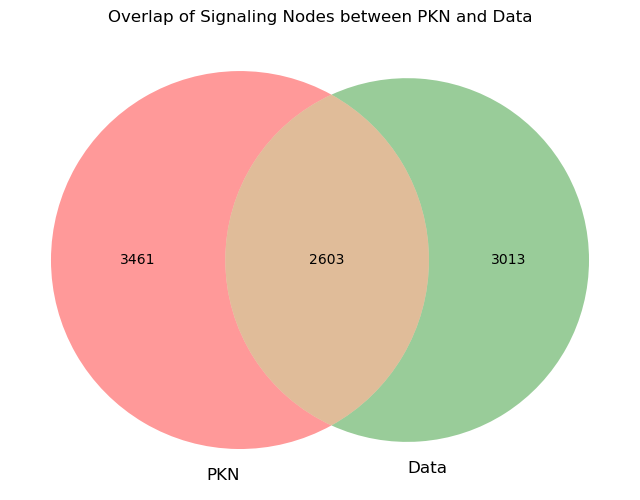

In [5]:
net = pd.read_csv('../data/pkn_signaling.tsv', sep = '\t', index_col = False)
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()
print("Number of unique proteins in net:", len(proteins_net))

proteins_map = map_protein['protein_id'].unique().tolist()
print("Number of unique protein_ids in map_protein:", len(proteins_map))

set_net = set(proteins_net)
set_map = set(proteins_map)

plt.figure(figsize=(8, 8))
venn_diagram = venn2([set_net, set_map], set_labels=('PKN', 'Data'))
plt.title("Overlap of Signaling Nodes between PKN and Data")
plt.show()

In [6]:
# Filter out proteins that are not in the PKN from map_protein
map_protein = map_protein[map_protein['protein_id'].isin(set_net)]
print("Filtered map_protein shape:", map_protein.shape)

# Filter also the corresponding phosphosites
valid_site_ids = map_protein['site_id'].unique().tolist()
print("Number of valid site_ids in filtered map_protein:", len(valid_site_ids))

phospho_data = phospho_data[phospho_data['site_id'].isin(valid_site_ids)]
print("Filtered phospho_data shape:", phospho_data.shape)

Filtered map_protein shape: (19065, 5)
Number of valid site_ids in filtered map_protein: 19065
Filtered phospho_data shape: (190650, 4)


In [7]:
# Widen data
phospho_data_wide = phospho_data.pivot(index='Drug_CL_Time', columns='site_id', values='Value')
phospho_data_wide = phospho_data_wide.reindex(sorted(phospho_data_wide.columns), axis=1)

# Sort the row index, which has format "EGF_Rx_y"
def sort_key(item):
    parts = item.split('_')
    time_val = int(parts[2])
    r_number = int(parts[1][1:])  # skip the letter "R"
    return (time_val, r_number)

sorted_rows = sorted(phospho_data_wide.index, key=sort_key)
phospho_data_wide = phospho_data_wide.loc[sorted_rows]
phospho_data_wide.index.name = "Drug_CL_Time"

display(phospho_data_wide.head())

site_id,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,"-0,030478801","-0,657851885","-0,246736006","0,077427647","-0,657851885","0,462425735","0,277434344","0,729609306","0,342797017","0,070812348",...,"-0,363885025","-1,527132316","-1,502397043","-1,001603375","-0,658777884","0,035326059","-1,063139147","-1,795758402","-2,589777375","-1,254588935"
EGF_R2_0,"-0,895855293","-0,831303772","-0,335640729","-0,352438577","-0,831303772","-0,258491921","-0,361850496","0,125242331","-0,454482381","-0,287467129",...,"-0,045587949","-1,714333499","-1,979430118","-1,257025782","-1,126934663","0,032173135","-1,271806191","-2,007758398","-2,516157845","-1,335665171"
EGF_R1_2,"-1,141777928","-0,457876717","-0,540829826","-0,032202021","-0,457876717","-0,250547118","-0,622722398","0,090442199","-0,118989685","-0,154651009",...,"-0,355033781","-1,7425204","-1,768622243","-1,564773052","-1,162621638","0,518072273","-1,181068808","-2,107800307","-2,65566385","-1,195929987"
EGF_R2_2,"-0,3329345","-0,265398627","-0,215250892","0,190632173","-0,265398627","0,563662082","0,074831","0,987147807","0,674478584","0,045945873",...,"-0,547264596","-0,969857462","-1,273526951","-1,020153671","-0,925320421","-0,161955453","-1,336020137","-1,793862661","-2,341803249","-0,984555919"
EGF_R1_4,"-0,297576586","-0,007715845","-0,170563592","0,046843059","-0,007715845","0,434181003","0,334414277","0,88000252","0,389007559","0,008397737",...,"-1,120297574","-1,350230939","-1,428485497","-0,924242918","-0,833852501","-0,087477961","-1,260145933","-1,440121431","-1,283719061","-1,306304603"


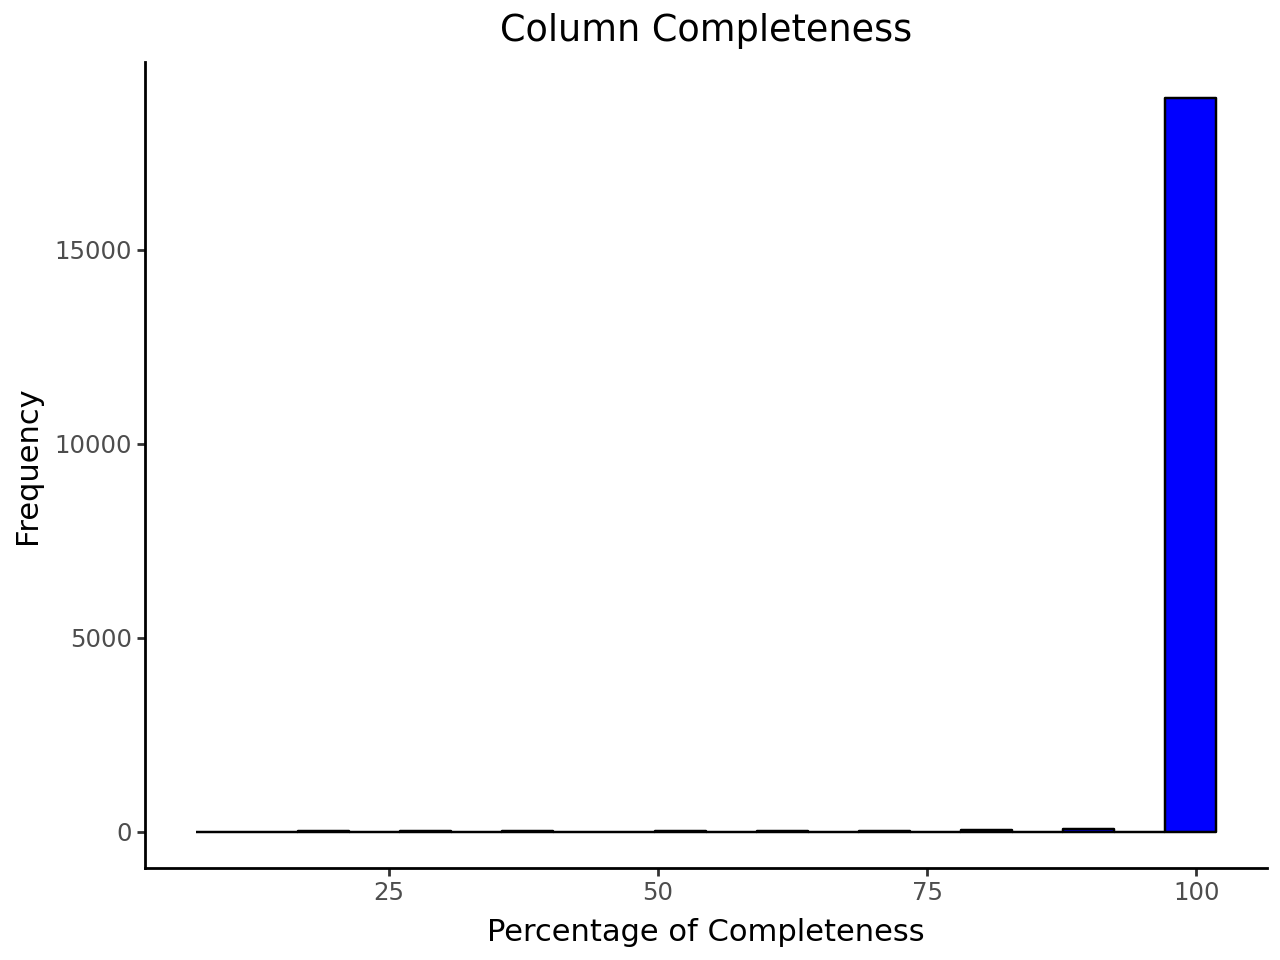

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


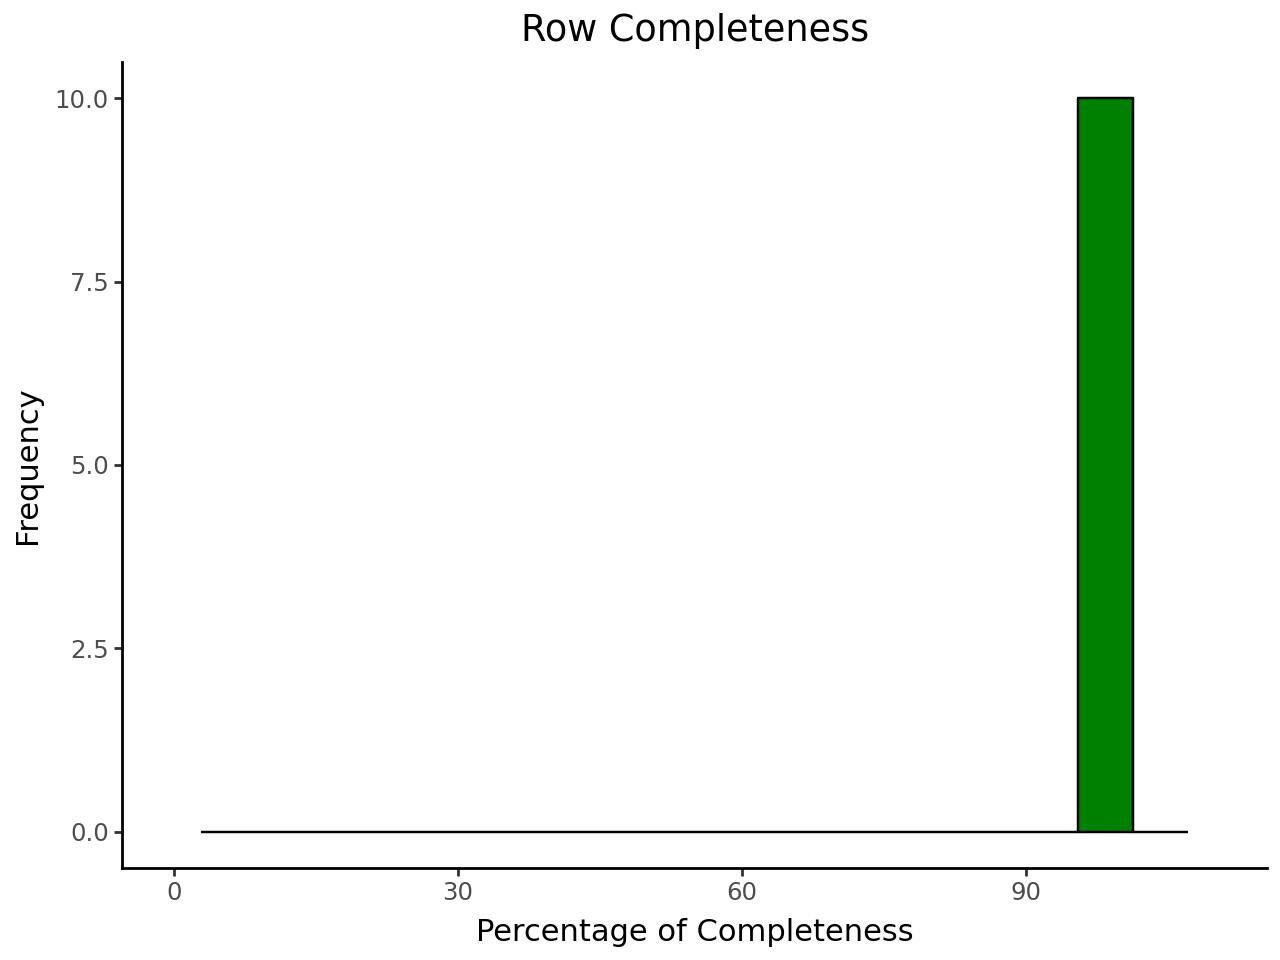

In [8]:
# Calculate the percentage of completeness across rows and columns (excluding Cell_line, Drug, and Time)
column_completeness = phospho_data_wide.notna().mean() * 100
row_completeness = phospho_data_wide.notna().mean(axis=1) * 100

column_completeness_df = pd.DataFrame({'Completeness': column_completeness})
row_completeness_df = pd.DataFrame({'Completeness': row_completeness})

# Histogram for column completeness
p1 = (p9.ggplot(column_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='blue', color='black') +
      p9.labs(title='Column Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.theme_classic())

# Histogram for row completeness
p2 = (p9.ggplot(row_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='green', color='black') +
      p9.labs(title='Row Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.xlim(0, 110) +
      p9.theme_classic())

p1.show()
p2.show()

Plot relations between proteins, peptides and phosphosites.

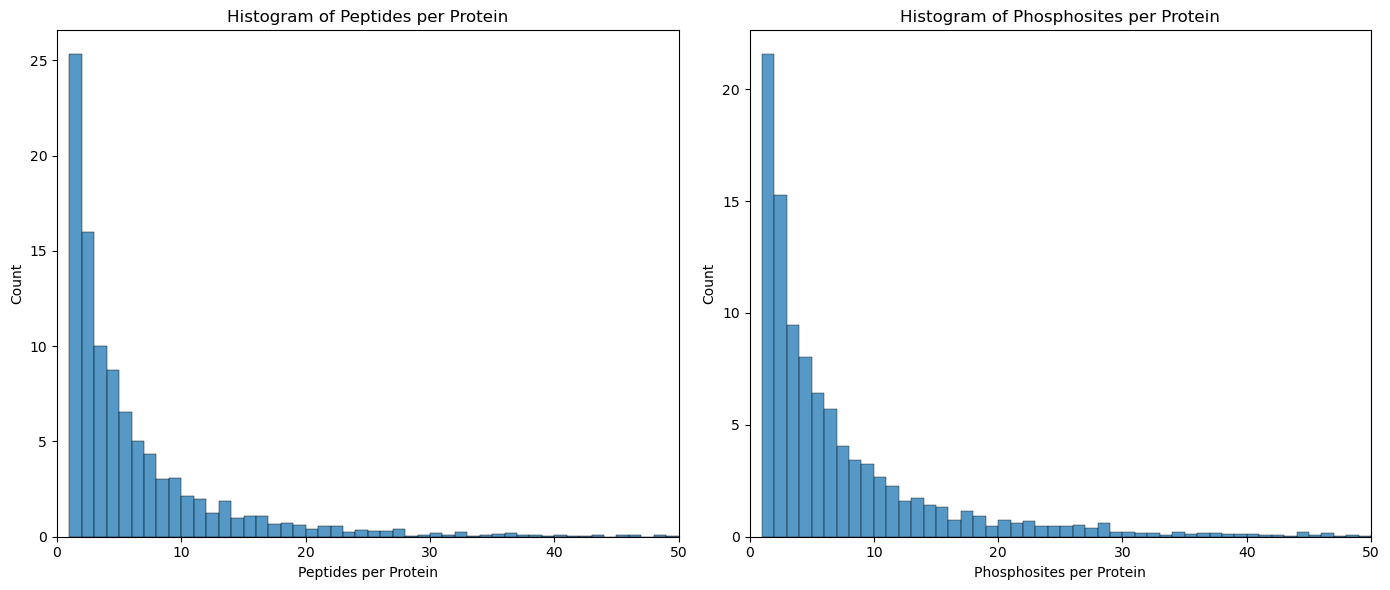

In [9]:
protein_aggregates = map_protein.groupby('protein_id').agg(
    peptides_per_protein=('modified_peptide_sequence', 'nunique'),
    phosphosites_per_protein=('phosphosite', 'nunique')
).reset_index()

# Plot histograms for peptides per protein and phosphosites per protein
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(protein_aggregates['peptides_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Peptides per Protein')
plt.xlabel('Peptides per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.subplot(1, 2, 2)
sns.histplot(protein_aggregates['phosphosites_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Phosphosites per Protein')
plt.xlabel('Phosphosites per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

## Prepare Data for Modeling

Based on the phospho_data create the input datasets `X`, `X_drug` and `X_cell` as well as the target dataset `y`. Based on the map_protein create the nodes_sites_map dataset.

In [10]:
# Create dictionaries with the drug doses and drug targets
for col in phospho_data.columns:
    if phospho_data[col].dtype == object:
        phospho_data[col] = phospho_data[col].str.replace(",", ".")
        try:
            phospho_data[col] = phospho_data[col].astype(float)
        except ValueError:
            pass  # column might not be numeric, so skip it
phospho_data[['Drug', 'Cell_line', 'Time']] = phospho_data['Drug_CL_Time'].str.split('_', expand=True)

drug_dose = {'EGF': 1}  # one-hot encoded as we don't have multiple doses
cell_lines = phospho_data['Cell_line'].unique()
drug_dose = {(drug, cell_line): dose for drug, dose in drug_dose.items() for cell_line in cell_lines}  # same drug concentration for all cell lines

drug_target = {
    'EGF': ['P01133'],
}


# Prepare X_data
unique_drug_cell_line = phospho_data[['Drug', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Cell_line'])
multiindex = pd.MultiIndex.from_frame(unique_drug_cell_line)
X_data = pd.DataFrame(index=multiindex)

unique_drugs = phospho_data['Drug'].unique()
for drug in unique_drugs:
    X_data[drug] = 0.0

for (drug, cell_line), dose in drug_dose.items():
    if (drug, cell_line) in X_data.index:
        X_data.loc[(drug, cell_line), drug] = dose

X_data.index = X_data.index.map('_'.join)
X_data.index.name = 'Drug_CL'

# Prepare X_drug
unique_targets = sorted(set(target for targets in drug_target.values() for target in targets))
X_drug = pd.DataFrame(0, index=unique_targets, columns=unique_drugs)

for drug, targets in drug_target.items():
    for target in targets:
        if target in X_drug.index:
            X_drug.loc[target, drug] = 1


# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)

unique_cell_lines = phospho_data['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for drug, cell_line in unique_drug_cell_line.itertuples(index=False):
    X_cell.loc[(drug, cell_line), cell_line] = 1

X_cell.index = X_cell.index.map('_'.join)
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = phospho_data.pivot(index=['Drug', 'Cell_line', 'Time'], columns='site_id', values='Value')
y_data.reset_index(inplace=True)
y_data['Drug_CL_Time'] = y_data[['Drug', 'Cell_line', 'Time']].astype(str).agg('_'.join, axis=1)
y_data.set_index('Drug_CL_Time', inplace=True)
y_data.drop(columns=['Drug', 'Cell_line', 'Time'], inplace=True)


# Prepare nodes_sites_map
unique_proteins = map_protein['protein_id'].unique()
unique_sites = map_protein['site_id'].unique()

nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)

for _, row in map_protein.iterrows():
    site = row['site_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


(2, 1)


,EGF
P01133,1


(1, 1)


,R1,R2
Drug_CL,,
EGF_R1,1,0
EGF_R2,0,1


(2, 2)


site_id,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.030479,-0.657852,-0.246736,0.077428,-0.657852,0.462426,0.277434,0.729609,0.342797,0.070812,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R1_12,0.108893,-0.079972,-0.106659,0.627377,-0.079972,0.556696,0.334158,1.032774,0.934160,0.170036,...,-1.172325,-0.800821,-0.815799,-0.699854,-0.855898,-0.172488,-1.305359,0.080308,-0.715368,-1.446721
EGF_R1_2,-1.141778,-0.457877,-0.540830,-0.032202,-0.457877,-0.250547,-0.622722,0.090442,-0.118990,-0.154651,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R1_4,-0.297577,-0.007716,-0.170564,0.046843,-0.007716,0.434181,0.334414,0.880003,0.389008,0.008398,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305
EGF_R1_8,-0.289470,-0.207775,-0.307863,0.272199,-0.207775,0.300089,0.035766,0.567482,0.279416,-0.049636,...,-0.732895,-1.529513,-1.441523,-0.700822,-1.141091,-0.257209,-1.256433,-0.596376,-0.948118,-1.449933


(10, 19065)


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S117s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S148s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:Y152y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(19065, 2603)


In [11]:
# Order Data
y_data = y_data[sorted(y_data.columns)]
temp = y_data.index.to_series().str.split('_', expand=True)
temp.columns = ['Drug', 'Cell_line', 'Time']
temp['Time'] = temp['Time'].astype(int)
y_data = y_data.loc[temp.sort_values(by=['Time','Drug','Cell_line']).index]

X_data = X_data.sort_index()
X_data = X_data[sorted(X_data.columns)]

X_cell = X_cell.sort_index()
X_cell = X_cell[sorted(X_cell.columns)]

X_drug = X_drug.sort_index()
X_drug = X_drug[sorted(X_drug.columns)]

nodes_sites_map = nodes_sites_map.sort_index()
nodes_sites_map = nodes_sites_map[sorted(nodes_sites_map.columns)]

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


(2, 1)


,EGF
P01133,1


(1, 1)


,R1,R2
Drug_CL,,
EGF_R1,1,0
EGF_R2,0,1


(2, 2)


site_id,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.030479,-0.657852,-0.246736,0.077428,-0.657852,0.462426,0.277434,0.729609,0.342797,0.070812,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.895855,-0.831304,-0.335641,-0.352439,-0.831304,-0.258492,-0.361850,0.125242,-0.454482,-0.287467,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-1.141778,-0.457877,-0.540830,-0.032202,-0.457877,-0.250547,-0.622722,0.090442,-0.118990,-0.154651,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,-0.332935,-0.265399,-0.215251,0.190632,-0.265399,0.563662,0.074831,0.987148,0.674479,0.045946,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,-0.297577,-0.007716,-0.170564,0.046843,-0.007716,0.434181,0.334414,0.880003,0.389008,0.008398,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


(10, 19065)


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S117s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S148s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:Y152y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(19065, 2603)


## Export Data

In [12]:
y_data.to_csv('../data/egf_y.csv', index=True)
X_data.to_csv('../data/egf_x.csv', index=True)
X_cell.to_csv('../data/egf_xcell.csv', index=True)
X_drug.to_csv('../data/egf_xdrug.csv', index=True)
nodes_sites_map.to_csv('../data/egf_nodes_sites_map.csv', index=True)